# Multi-Class Text Classififcation Task

In [2]:
#imports cell 

#basic imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#NLP imports
import nltk
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import re

#Classification imports
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier,LogisticRegression

## Step 1: Data 
<ol>
    
    1.Loading Data into a dataframe.
    
    2.Understanding and Visualizing data.
    
    3.Cleaning and preprocessing data.
    
    4.Splitting data into test and train datasets.

In [3]:
#loading data into a dataframe.
dataframe = pd.read_csv("./Job titles and industries.csv")
dataframe.head()

,job title,industry
0,technical support and helpdesk supervisor - co...,IT
1,senior technical support engineer,IT
2,head of it services,IT
3,js front end engineer,IT
4,network and telephony controller,IT


### Understanding Data

In [4]:
#Each job title has an industry type. 
#The industry type is the classes and the job titles are our instances.
dataframe.info()
print("\nThere are only ",len(dataframe['job title'].unique()),"unique entries in job titles.")
print("\nThere are 4 Classes in the data: ",dataframe['industry'].unique())
classes = np.array(dataframe['industry'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8586 entries, 0 to 8585
Data columns (total 2 columns):
job title    8586 non-null object
industry     8586 non-null object
dtypes: object(2)
memory usage: 134.2+ KB

There are only  3890 unique entries in job titles.

There are 4 Classes in the data:  ['IT' 'Marketing' 'Education' 'Accountancy']


### Visualize the distribution of classes.

<Figure size 720x432 with 0 Axes>

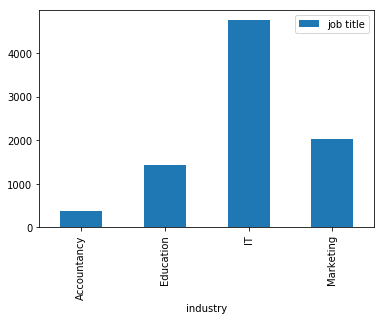

In [5]:
plt.figure(figsize=(10,6));
dataframe.groupby('industry').count().plot.bar(ylim=0);
plt.show();

### Cleaning the data: Removing duplicates

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3890 entries, 0 to 8585
Data columns (total 2 columns):
job title    3890 non-null object
industry     3890 non-null object
dtypes: object(2)
memory usage: 91.2+ KB


<Figure size 720x432 with 0 Axes>

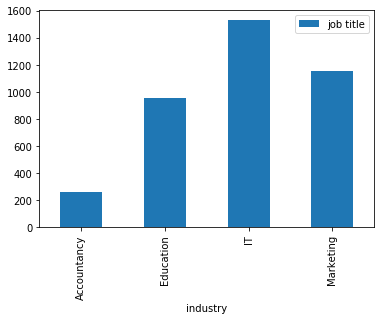

In [6]:
cleanframe = dataframe.drop_duplicates(subset="job title")
cleanframe.info()
#show the new classes distribution after removing duplicates.
plt.figure(figsize=(10,6));
cleanframe.groupby('industry').count().plot.bar(ylim=0);
plt.show();

### Cleaning the data: Text Pre-processing

In [7]:
def clean_text(text):
    """
        text: a string 
        return: modified clean string
    """
    result = ""
    for token in simple_preprocess(text):
        if token not in STOPWORDS and len(token) >= 2:
            token = token.lower() # lowercase text
            result+=token+" "     # append to result
    return result

cleanframe['job title'] = cleanframe['job title'].map(clean_text)
cleanframe.head()

/home/zawawy/Public/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


,job title,industry
0,technical support helpdesk supervisor county b...,IT
1,senior technical support engineer,IT
2,head services,IT
3,js end engineer,IT
4,network telephony controller,IT


### Splitting data into test and train datasets + Dealing with class imbalance

In [8]:
X = cleanframe['job title']
y = cleanframe['industry']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)
weights = compute_sample_weight("balanced",y_train)

## The Model 

### Approach 1: Naive Bayes classifier for multinomial models

In [9]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),])

nb.fit(X_train, y_train, **{'clf__sample_weight': weights})

y_pred = nb.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))

accuracy 0.8756423432682425


### Approach 2: Linear SVM

In [20]:
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),])

sgd.fit(X_train, y_train, **{'clf__sample_weight': weights})

y_pred = sgd.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))

accuracy 0.8859198355601233


### Approach 3: Logisistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train, **{'clf__sample_weight': weights})

y_pred = logreg.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))

accuracy 0.8653648509763617


### Selecting the final model from one of the approaches and evaluating further than just accuracy
Since all three approaches were very close in results to each other with 1% up or down differences in accuracy score. I choose their highest to be my final model and will conclude my task with some more different model evalutions.

### Showing the Heat Map pf predicted classes
As we can see in the result, the heat map is around the main diagonal where we want it to be normally. There are some minor mis-classifications.

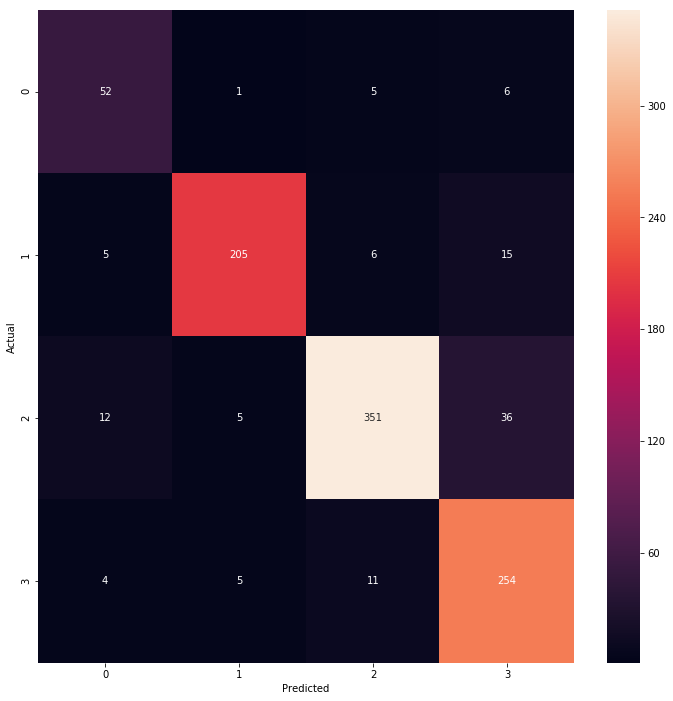

In [21]:
import seaborn as sns
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Evaluating using F1-score for classes 

In [22]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

          IT       0.71      0.81      0.76        64
   Marketing       0.95      0.89      0.92       231
   Education       0.94      0.87      0.90       404
 Accountancy       0.82      0.93      0.87       274

   micro avg       0.89      0.89      0.89       973
   macro avg       0.85      0.87      0.86       973
weighted avg       0.89      0.89      0.89       973



### Save the final selected Model to a file to use directly in the RESTfull API script.

In [23]:
from joblib import dump, load
dump(sgd, 'model.joblib')

['model.joblib']